In [21]:
import numpy as np

In [17]:
from karabo_data import H5File, stack_detector_data
from karabo_data.geometry2 import AGIPD_1MGeometry

Now we'll look at some data from the European XFEL.

For this example we'll use the same data used in a pubilcation on megahertz serial crystallography ([10.1038/s41467-018-06156-7](https://www.nature.com/articles/s41467-018-06156-7)). The data is available on [CXIDB](https://cxidb.org/id-83.html)

Here we use a subset of that data which is at:

In [6]:
run_file_path = "./examples/euxfel/data-subset.h5"

In [7]:
from h5glance import H5Glance

In [8]:
H5Glance(run_file_path)

As you can see, there is a decent amount of complexity in the file. Working with all these files directly would be quite awkward.

Instead we use `karabo_data` to build a `karabo_data.reader.DataCollection` object. This object is what is used to select and load data in:

In [9]:
import karabo_data

In [10]:
run = karabo_data.H5File(run_file_path)

The `info` method can be used to quickly give a summary of the run. We can see all of the sources, as well as the number of 'trains' (group of X-ray pulses) and the number of frames per train (number of pulses recorded per train by the detector):

In [11]:
run.info()

# of trains:    4
Duration:       0:00:00.300000
First train ID: 76961506
Last train ID:  76961509

16 detector modules (SPB_DET_AGIPD1M-1)
  e.g. module SPB_DET_AGIPD1M-1 0 : 512 x 128 pixels
  64 frames per train, 256 total frames

0 instrument sources (excluding detectors):

0 control sources:



We can then select a source, and load in some trains for this selection:

In [12]:
run_image_data = run.select("*/DET/*", "image.*")  # Only look at detectors with image data in them

In [13]:
trainid, run_train_data = run_image_data.train_from_id(76961508)  # Load train with id "76961508"

Now `run_train_data` contains only data from instruments with an `image.*` key in their HDF5 file, from the 100th train in the run. This data is split over multiple files, and `karabo_data` brings this all together into one convenient data collection.

Here we can print off the name of the source and the size of the image data it contains:

In [14]:
[print(d['metadata']['source'], ": ", d['image.data'].shape) for d in run_train_data.values()];

SPB_DET_AGIPD1M-1/DET/11CH0:xtdf :  (64, 512, 128)
SPB_DET_AGIPD1M-1/DET/9CH0:xtdf :  (64, 512, 128)
SPB_DET_AGIPD1M-1/DET/7CH0:xtdf :  (64, 512, 128)
SPB_DET_AGIPD1M-1/DET/12CH0:xtdf :  (64, 512, 128)
SPB_DET_AGIPD1M-1/DET/0CH0:xtdf :  (64, 512, 128)
SPB_DET_AGIPD1M-1/DET/2CH0:xtdf :  (64, 512, 128)
SPB_DET_AGIPD1M-1/DET/13CH0:xtdf :  (64, 512, 128)
SPB_DET_AGIPD1M-1/DET/14CH0:xtdf :  (64, 512, 128)
SPB_DET_AGIPD1M-1/DET/10CH0:xtdf :  (64, 512, 128)
SPB_DET_AGIPD1M-1/DET/3CH0:xtdf :  (64, 512, 128)
SPB_DET_AGIPD1M-1/DET/1CH0:xtdf :  (64, 512, 128)
SPB_DET_AGIPD1M-1/DET/4CH0:xtdf :  (64, 512, 128)
SPB_DET_AGIPD1M-1/DET/5CH0:xtdf :  (64, 512, 128)
SPB_DET_AGIPD1M-1/DET/6CH0:xtdf :  (64, 512, 128)
SPB_DET_AGIPD1M-1/DET/8CH0:xtdf :  (64, 512, 128)
SPB_DET_AGIPD1M-1/DET/15CH0:xtdf :  (64, 512, 128)


We can then use `karabo_data` to combine these multiple modules together, and assemble them into an image:

In [18]:
stacked_data = stack_detector_data(run_train_data, "image.data")
stacked_data.shape

(64, 16, 512, 128)

The `stack_detector_data` function takes in a collection of data, and a key to stack over. It takes `run_train_data`, pulls out the `image.data` values (which are separate entries in a dictionary) and concatenates them into a single numpy array

The first dimension (`64`) is the number of frames recorded by the detector, the second dimension (`16`) is the number of detector modules, and the final two dimensions (`512, 128`) are the pixel coordinates

The AGIPD detector is made up out of four quadrants, each with four modules in them, which is why the second dimension holds 16 values. To plot a useful image from this we need to position the data from these quadrants, this is done with a geometry object:

In [19]:
geom = AGIPD_1MGeometry.from_quad_positions(quad_pos=[
    (-525, 625),
    (-550, -10),
    (520, -160),
    (542.5, 475),
])

Now we can use this geometry to plot our data. Looking at a single pulse, the 3rd one in this case, we see:

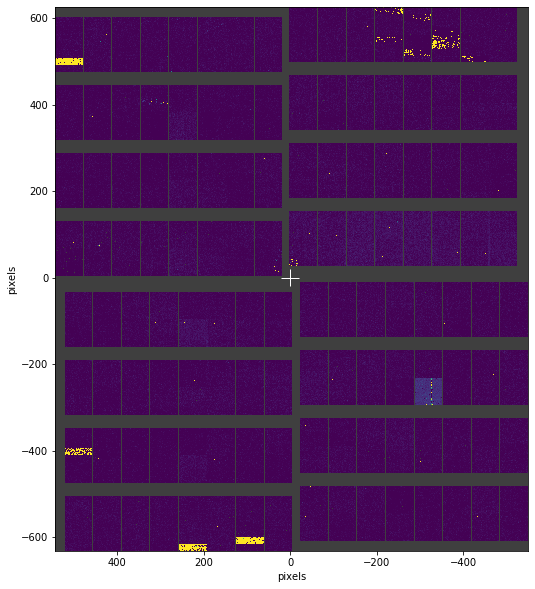

In [24]:
geom.plot_data_fast(np.clip(stacked_data[3], 0, 400))

Not much. And for the fourth:

In [22]:
geom.plot_data_fast(np.clip(stacked_data[4], 0, 400))

For this run the detector recorded twice as fast as the laser pulses, so every other frame is blank. This is done to get a background reading. We can do some basic background substraction:

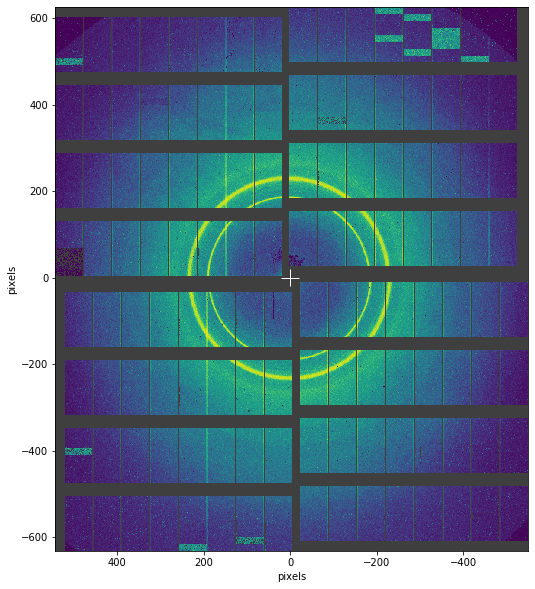

In [23]:
bkg_subtracted = stacked_data[::2] - stacked_data[1::2]
geom.plot_data_fast(np.mean(np.clip(bkg_subtracted, 0, 300), axis=0))

Which results in a nice, clear image of powder rings!